In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

## 1

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

## 2

In [44]:
test = pd.read_csv('../data/ab-test.csv')
test = (test[(test['group'] == 'test') & (test['time'] == 'after')]
        .set_index('uid')
)

In [43]:
pageviews = pd.io.sql.read_sql(
    """
    SELECT uid, COUNT(*) AS pageviews
    FROM pageviews
    WHERE uid LIKE "user_%"
    GROUP BY uid;
    """,
    con=conn
)
pageviews = pageviews.set_index('uid')

commits = pd.io.sql.read_sql(
    """
    SELECT uid, COUNT(*) AS num_commits
    FROM checker
    WHERE uid LIKE "user_%" AND labname <> "project1"
    GROUP BY uid
    """,
    con=conn
)
commits = commits.set_index('uid')

In [45]:
test = (test
        .merge(pageviews, on='uid', how='left')
        .merge(commits, on='uid', how='left')
        .reset_index()
        .drop(columns=['time', 'group', 'uid'])
        .rename(columns={'diff': 'avg_diff'})
)

array([[<Axes: xlabel='avg_diff', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='num_commits', ylabel='avg_diff'>],
       [<Axes: xlabel='avg_diff', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='num_commits', ylabel='pageviews'>],
       [<Axes: xlabel='avg_diff', ylabel='num_commits'>,
        <Axes: xlabel='pageviews', ylabel='num_commits'>,
        <Axes: xlabel='num_commits', ylabel='num_commits'>]], dtype=object)

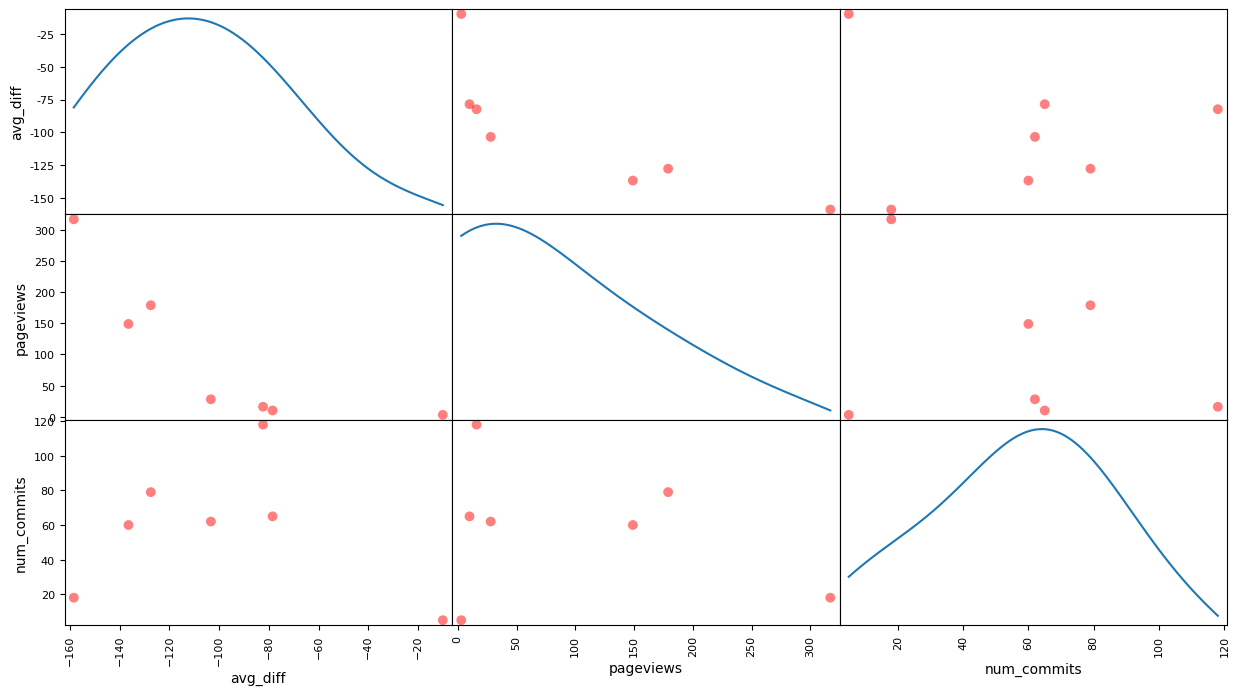

In [56]:
pd.plotting.scatter_matrix(test, figsize=(15, 8),
                           diagonal='kde', c='red',
                           s=200, linewidth=3)

## 3

In [57]:
conn.close()

## 4

Can we say that if a user has a low number of pageviews, then they likely have a low number of commits? - No

Can we say that if a user has a low number of pageviews, then they likely have a small average difference between the first commit and the lab deadline? - Yes

Can we say that there are many users with a low number of commits and a few with a high number of commits? - No

Can we say that there are many users with a small average difference and a few with a large average difference? - No